# GoogleNet

In [1]:
import tensorflow as tf

In [2]:
num_classes = 1000
input_shape = [244, 244, 3]

batch_size = 16
num_epochs = 10

## Inception module

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,\
                                    GlobalAveragePooling2D, Dense, Dropout, \
                                    Flatten, concatenate, Resizing

from typing import Dict
from IPython.display import Image

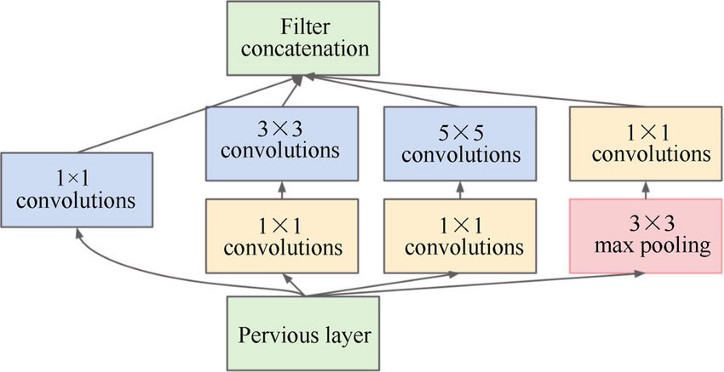

In [4]:
Image('image/inception_module.png')

In [5]:
def inception(filters: Dict[str, int]):
    def layer_fn(x):
        path1 = Conv2D(filters=filters['1x1'], kernel_size=1, 
                       padding='valid', activation='relu')(x)

        path2 = Conv2D(filters=filters['3x3_reduce'], kernel_size=1, 
                       padding='valid', activation='relu')(x)
        path2 = Conv2D(filters=filters['3x3'], kernel_size=3, 
                       padding='same', activation='relu')(path2)

        path3 = Conv2D(filters=filters['5x5_reduce'], kernel_size=1, 
                       padding='valid', activation='relu')(x)
        path3 = Conv2D(filters=filters['5x5'], kernel_size=5, 
                       padding='same', activation='relu')(path3)

        path4 = MaxPooling2D(pool_size=3, strides=(1, 1), 
                          padding='same')(x)
        path4 = Conv2D(filters=filters['pool_proj'], kernel_size=1, 
                       padding='valid', activation='relu')(path4)

        return concatenate([path1, path2, path3, path4], axis=-1)
    return layer_fn

# GoogleNet

In [6]:
from tensorflow.keras import Model, Input

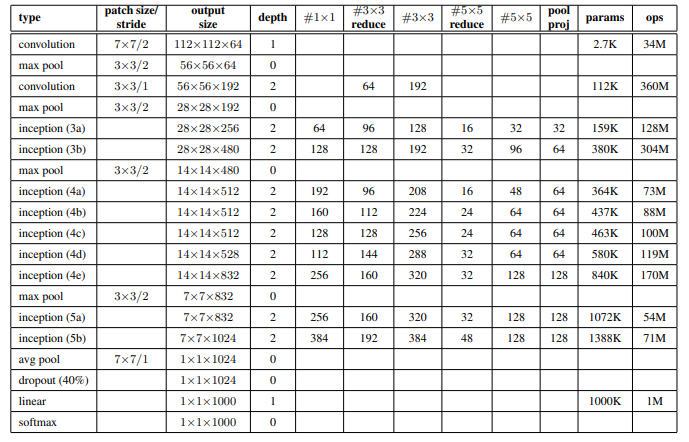

In [7]:
Image('image/googlenet_architecture.png')

In [8]:
filters_3a = {"1x1": 64, 
              "3x3_reduce": 96, "3x3": 128,
              "5x5_reduce": 16, "5x5": 32,
              "pool_proj": 32}
filters_3b = {"1x1": 128, 
              "3x3_reduce": 128, "3x3": 192,
              "5x5_reduce": 32, "5x5": 96,
              "pool_proj": 64}

filters_4a = {"1x1": 192, 
              "3x3_reduce": 96, "3x3": 208,
              "5x5_reduce": 16, "5x5": 48,
              "pool_proj": 64}
filters_4b = {"1x1": 160, 
              "3x3_reduce": 112, "3x3": 224,
              "5x5_reduce": 24, "5x5": 64,
              "pool_proj": 64}
filters_4c = {"1x1": 128, 
              "3x3_reduce": 128, "3x3": 256,
              "5x5_reduce": 24, "5x5": 64,
              "pool_proj": 64}
filters_4d = {"1x1": 112, 
              "3x3_reduce": 114, "3x3": 288,
              "5x5_reduce": 32, "5x5": 64,
              "pool_proj": 64}
filters_4e = {"1x1": 256, 
              "3x3_reduce": 160, "3x3": 320,
              "5x5_reduce": 32, "5x5": 128,
              "pool_proj": 128}

filters_5a = {"1x1": 256, 
              "3x3_reduce": 160, "3x3": 320,
              "5x5_reduce": 32, "5x5": 128,
              "pool_proj": 128}
filters_5b = {"1x1": 384, 
              "3x3_reduce": 192, "3x3": 384,
              "5x5_reduce": 48, "5x5": 128,
              "pool_proj": 128}

In [9]:
def GoogleNet(input_shape, num_classes):
    def aux_classifier(name):
        def layer_fn(x):
            x = AveragePooling2D(pool_size=5, strides=3)(x)
            x = Conv2D(filters=128, kernel_size=1, 
                       padding='valid', activation='relu')(x)
            x = Flatten()(x)
            x = Dense(units=1024, activation='relu')(x)
            x = Dropout(0.7)(x)
            x = Dense(units=num_classes, activation='softmax', name=name+'_output')(x)
            return x
        return layer_fn
    
    input = Input(shape=input_shape)
    x = Resizing(height=224, width=224, interpolation="bilinear")(input)
    
    x = Conv2D(filters=64, kernel_size=7, strides=2,
              padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = Conv2D(filters=64, kernel_size=1, 
                       padding='valid', activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=3,
                   padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # block3
    x = inception(filters=filters_3a)(x)
    x = inception(filters=filters_3b)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # block4
    x = inception(filters=filters_4a)(x)
    aux1 = aux_classifier(name='aux1')(x)
    x = inception(filters=filters_4b)(x)
    x = inception(filters=filters_4c)(x)
    x = inception(filters=filters_4d)(x)
    aux2 = aux_classifier(name='aux2')(x)
    x = inception(filters=filters_4e)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    #block5
    x = inception(filters=filters_5a)(x)
    x = inception(filters=filters_5b)(x)  
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output = Dense(units=num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input, outputs=[output, aux1, aux2])
    
    return model

In [10]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [11]:
model = GoogleNet(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                              

## Training exmaple

In [12]:
# cifar10 = tf.keras.datasets.cifar10
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# x_train=x_train / 255.0
# x_test=x_test / 255.0

# num_train = len(x_train)
# num_val = len(x_test)

# print('# for train : %d'%(num_train))
# print('# for valid : %d'%(num_val))

In [13]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

num_train = len(x_train)
num_val = len(x_test)

print('# for train : %d'%(num_train))
print('# for valid : %d'%(num_val))

# for train : 60000
# for valid : 10000


In [19]:
train_dataset = (x_train, [y_train, y_train, y_train])
val_dataset = (x_test, [y_test, y_test, y_test])

num_classes = 10
input_shape = [32, 32, 3]

batch_size = 32
num_epochs = 10

In [20]:
model = GoogleNet(input_shape, num_classes)

In [21]:
optimizer = 'adam'
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

model.compile(optimizer=optimizer,
             loss=['sparse_categorical_crossentropy',
                  'sparse_categorical_crossentropy',
                  'sparse_categorical_crossentropy'],
             loss_weights=[1, 0.3, 0.3],
             metrics=[accuracy_metric, top5_accuracy_metric])

In [22]:
import os

model_dir = './models/googlenet'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                    restore_best_weights=True),
    
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, 
                                   histogram_freq=0, 
                                   write_graph=True,
                                   write_images=True,
                                   update_freq=100),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

In [23]:
import math

train_steps_per_epoch = math.ceil(num_train / batch_size)
val_steps_per_epoch = math.ceil(num_val / batch_size)

basic_history = model.fit(*train_dataset,
                        epochs=num_epochs,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=(val_dataset),
                        validation_steps=val_steps_per_epoch,
                        verbose=1, callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - 178s 94ms/step - loss: 0.5405 - output_loss: 0.3626 - aux1_output_loss: 0.2784 - aux2_output_loss: 0.3146 - output_acc: 0.8758 - output_top5_acc: 0.9668 - aux1_output_acc: 0.9075 - aux1_output_top5_acc: 0.9831 - aux2_output_acc: 0.8944 - aux2_output_top5_acc: 0.9729 - val_loss: 0.1170 - val_output_loss: 0.0847 - val_aux1_output_loss: 0.0498 - val_aux2_output_loss: 0.0579 - val_output_acc: 0.9767 - val_output_top5_acc: 0.9999 - val_aux1_output_acc: 0.9846 - val_aux1_output_top5_acc: 0.9997 - val_aux2_output_acc: 0.9825 - val_aux2_output_top5_acc: 0.9999
Epoch 2/10
1875/1875 [==============================] - 177s 95ms/step - loss: 0.1153 - output_loss: 0.0727 - aux1_output_loss: 0.0718 - aux2_output_loss: 0.0703 - output_acc: 0.9793 - output_top5_acc: 0.9996 - aux1_output_acc: 0.9788 - aux1_output_top5_acc: 0.9997 - aux2_output_acc: 0.9802 - aux2_output_top5_acc: 0.9996 - val_loss: 0.0693 - val_output_loss: 0.0463 - val_aux1_output

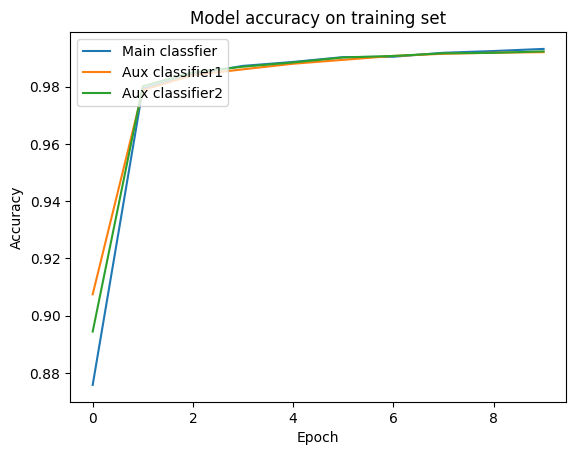

In [29]:
import matplotlib.pyplot as plt

plt.plot(basic_history.history['output_acc'])
plt.plot(basic_history.history['aux1_output_acc'])
plt.plot(basic_history.history['aux2_output_acc'])
plt.title('Model accuracy on training set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Main classfier', 'Aux classifier1', 'Aux classifier2'], loc='upper left')
plt.show()

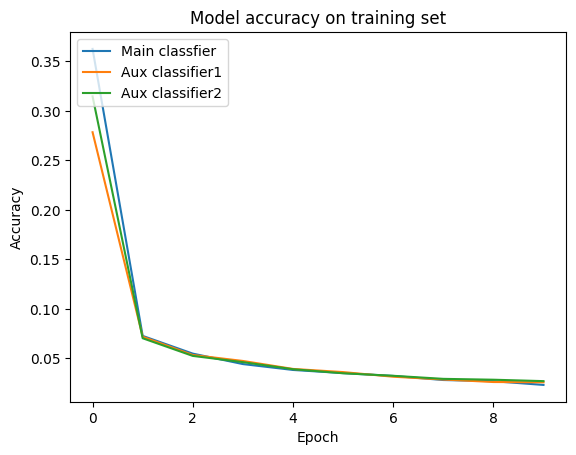

In [61]:
plt.clf()
plt.plot(basic_history.history['output_loss'])
plt.plot(basic_history.history['aux1_output_loss'])
plt.plot(basic_history.history['aux2_output_loss'])
plt.title('Model accuracy on training set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Main classfier', 'Aux classifier1', 'Aux classifier2'], loc='upper left')
plt.show()

In [62]:
import io
import random

import numpy as np

def image_grid():
    test_images = map(lambda x: int(x*255), x_test.numpy())
    pred, _, _ = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    figure = plt.figure(figsize=(10,10))
    
    random_index = random.sample(range(len(x_test)), 25)
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=str(pred[random_index[i]]))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[random_index[i]], cmap=plt.cm.binary)

    return figure

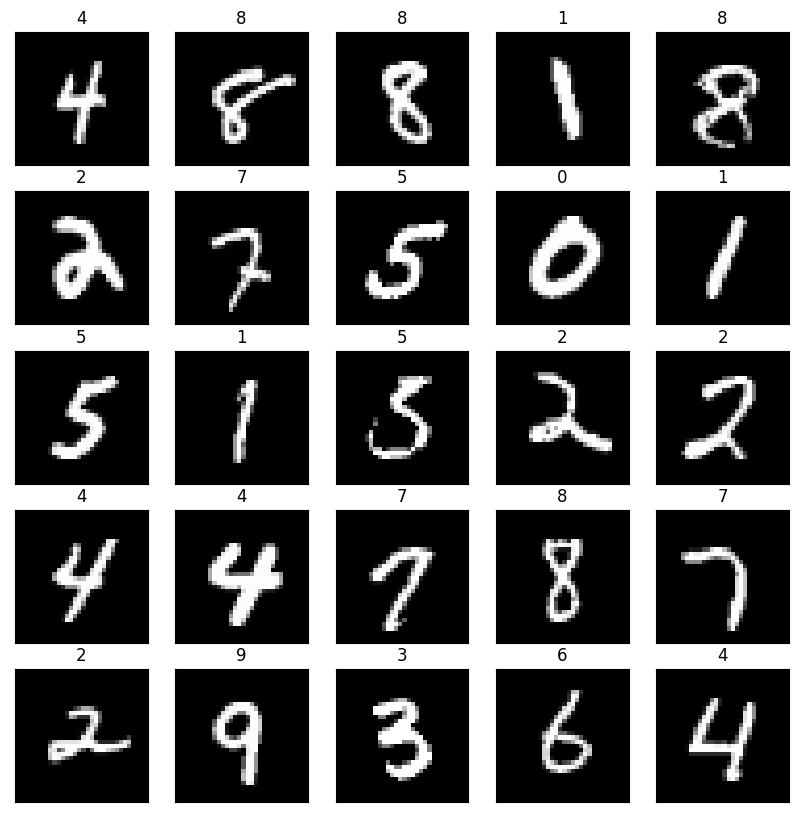

In [63]:
image_grid()